### **Question 2**


In [0]:
import pandas as pd
import numpy as np
from scipy.special import expit  # the expit function is the same as logistic sigmoid function
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [21]:
df = pd.read_excel('./Dataset_Question2.xlsx')
stats = df.describe()
stats = stats.drop('count', axis = 0)
pd.set_option('display.max_columns', None)
print(stats.T)

                                     mean         std        min          25%  \
Temperature                    546.766430   86.858780   400.3100   469.735000   
Pressure                        25.493270   14.252407     1.0600    12.725000   
Feed Flow rate                 125.029060   43.508159    50.0300    88.587500   
Coolant Flow rate             2295.797770  763.680625  1002.5300  1635.682500   
Inlet reactant concentration     0.302692    0.116062     0.1003     0.199075   

                                     50%          75%        max  
Temperature                    545.80000   618.877500   699.8700  
Pressure                        25.37500    37.820000    49.8900  
Feed Flow rate                 124.59000   162.562500   199.9600  
Coolant Flow rate             2268.71000  2983.692500  3595.6200  
Inlet reactant concentration     0.30885     0.401625     0.4996  


In [12]:
# stats.T

,mean,std,min,25%,50%,75%,max
Temperature,546.766430,86.858780,400.3100,469.735000,545.80000,618.877500,699.8700
Pressure,25.493270,14.252407,1.0600,12.725000,25.37500,37.820000,49.8900
Feed Flow rate,125.029060,43.508159,50.0300,88.587500,124.59000,162.562500,199.9600
Coolant Flow rate,2295.797770,763.680625,1002.5300,1635.682500,2268.71000,2983.692500,3595.6200
Inlet reactant concentration,0.302692,0.116062,0.1003,0.199075,0.30885,0.401625,0.4996


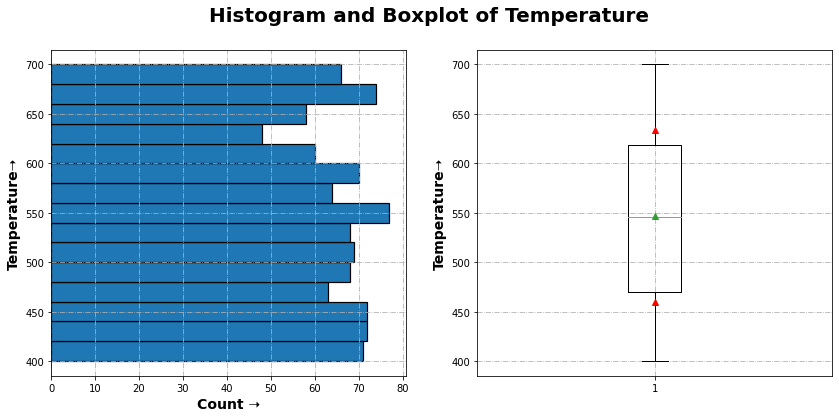

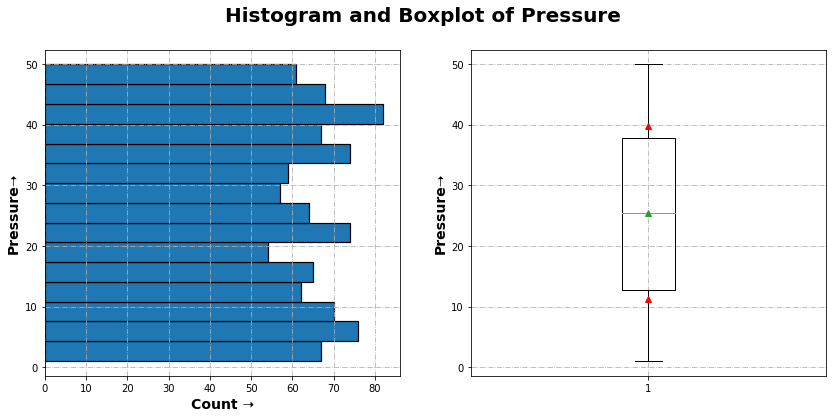

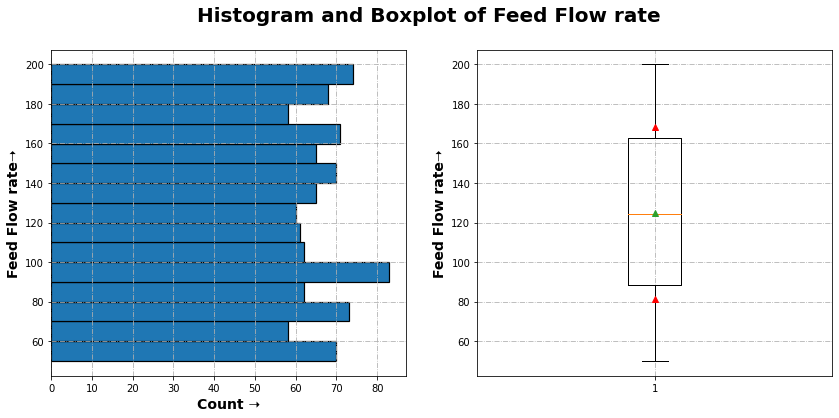

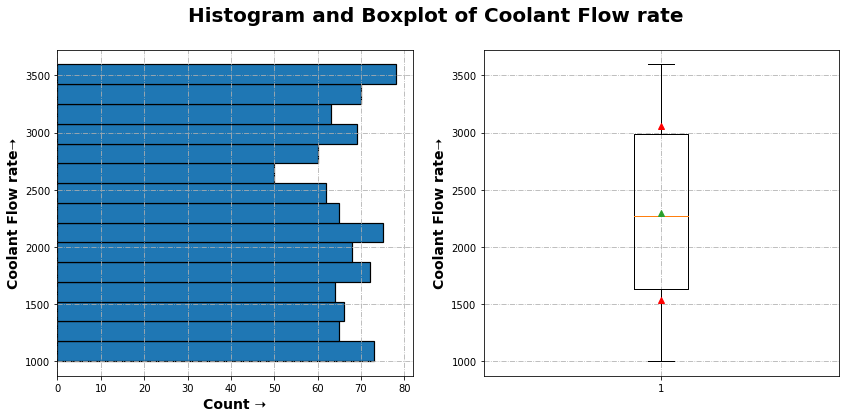

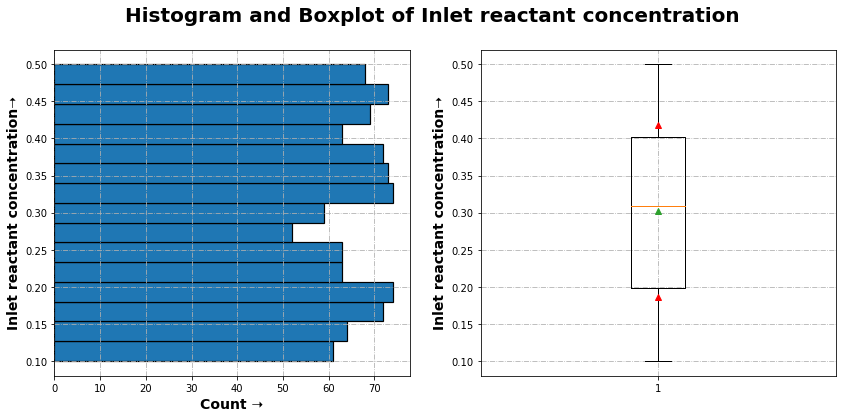

In [6]:
data = df.to_numpy()

def hist_box_plotter(column):
    plt.figure(figsize=(14,6))
    plt.suptitle("Histogram and Boxplot of "+column, fontsize = 20, fontweight = 'bold')
    plt.subplot(121)
    plt.grid(b=True, ls = '-.', zorder=-100)
    plt.hist(df[column], bins=15, edgecolor='black', linewidth=1.2, orientation="horizontal")
    plt.xlabel('Count \u279d', fontsize = 14, fontweight = 'bold')
    plt.ylabel(column+'\u279d', fontsize = 14, fontweight = 'bold')
    std_above = np.mean(df[column]) + np.std(df[column])
    std_below = np.mean(df[column]) - np.std(df[column])
    plt.subplot(122)
    plt.boxplot(df[column], showmeans = True)
    plt.plot((1,1), (std_above, std_below), 'r^')
    plt.grid(b=True, ls = '-.')
    plt.ylabel(column+'\u279d', fontsize = 14, fontweight = 'bold')
    plt.show()

hist_box_plotter('Temperature')
hist_box_plotter('Pressure')
hist_box_plotter('Feed Flow rate')
hist_box_plotter('Coolant Flow rate')
hist_box_plotter('Inlet reactant concentration')

In [0]:
data = df.to_numpy()
norm_data = data
# STANDARDISATION OF THE DATA - ZERO MEAN, UNIT VARIANCE
norm_data[:,:-1] = norm_data[:,:-1] - stats.T['mean'][np.newaxis,:]
norm_data[:,:-1] = norm_data[:,:-1]/stats.T['std'][np.newaxis,:]
# Turning Pass and Fail into numerical labels
norm_data[norm_data == 'Pass'] = 1
norm_data[norm_data == 'Fail'] = 0

In [0]:
from sklearn.model_selection import train_test_split

# Splitting train and test data
train_data, test_data = train_test_split(norm_data, test_size = 0.3)

In [0]:
# Function that adds a bias constant to the state, so that theta can be learnt along with a bias term  
def include_bias(x_set):
    biased = np.concatenate((np.ones((len(x_set), 1)), x_set), axis = 1)
    return biased

# LOGISTIC REGRESSION MODEL
def logistic_regression(X_train, Y_train, alpha):
    weight = 0
    Y_train = (Y_train - (Y_train==0))[:, np.newaxis]  # Turning the (0, 1) labels into (-1, 1) labels, to implement our Loss Function
    X_train = include_bias(X_train)
    X_train = X_train.astype('float128')
    Y_train = Y_train.astype('float128')
    w = np.random.uniform(low = -50, high = 50, size=(X_train.shape[1], 1)).astype('float128')  # Randomly initialised weights
    for ite in range(1000):
        # empirical_risk = np.sum(np.log(1+np.exp(-1*np.multiply(Y_train, np.matmul(X_train, w)))))
        grad = np.sum(-1*expit(-np.multiply(Y_train, np.matmul(X_train, w)))*Y_train*X_train, axis = 0)   # Gradient of the Loss/Empirical Risk Function
        w_old = w
        w = w - alpha*grad[:,np.newaxis]  # Gradient Descent step
        alpha = 0.99*alpha
        if (np.linalg.norm(w-w_old) < 0.0001):
            break  # Break if near convergence
    weight = w
    empirical_risk = np.sum(np.log(1/expit(np.multiply(Y_train, np.matmul(X_train, weight)))))
    return weight, empirical_risk

In [0]:
weight_list, risk_list = [], []
for i in range (50): # MULTIPLE INITIALISATIONS
    weight, empirical_risk = np.squeeze(logistic_regression(train_data[:,:-1], train_data[:,-1], alpha = 0.01))
    weight_list.append(weight)
    risk_list.append(empirical_risk)
minpos = risk_list.index(min(risk_list)) 
best_weights = weight_list[minpos] # SELECTING THE GLOBAL MINIMUM OUT OF THE EXISTING CALCULATED MINIMA

In [14]:
print("The optimal weights are: "+ str(best_weights))

The optimal weights are: [[ 1.07873657]
 [-0.18268183]
 [-0.51773874]
 [-0.51581601]
 [ 3.42206412]
 [-0.15359996]]


In [11]:
# Function to evaluate accuracy
def find_accuracy(X_test, Y_test, w):
    X_test = include_bias(X_test)
    Y_test_pred = np.squeeze(np.sign((np.matmul(X_test, w))))
    Y_test_pred = Y_test_pred + (Y_test_pred==-1)
    accuracy = np.sum(Y_test_pred == Y_test)/len(Y_test)
    return Y_test_pred, accuracy

preds, accuracy = find_accuracy(test_data[:,:-1], test_data[:,-1], best_weights)
print("The accuracy of the Logistic Classifier on test data = " + str(accuracy*100) + "%")

The accuracy of the Logistic Classifier on test data = 95.33333333333334%


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

conf_matrix = confusion_matrix(test_data[:,-1].astype(int), preds.astype(int))
f1score = f1_score(test_data[:,-1].astype(int), preds.astype(int))

labels = np.unique(test_data[:,-1].astype(int))

conf_matrix = pd.DataFrame(conf_matrix, index=labels, columns=labels)
print("Confusion Matrix:")
print(conf_matrix, "\n")
print("F1 Score = " + str(f1score))

Confusion Matrix:
     0    1
0  112    6
1    8  174 

F1 Score = 0.9613259668508287
